<a href="https://colab.research.google.com/github/sazzeb/simulated-annealing/blob/main/Part_B_Projects_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings


In [ ]:

def heuristic_function(network, sink):
    return sum(flow for (u, v), flow in network['flow'].items() if v == sink)

In [ ]:
def _simple_path_from_sink(graph, source, sink, curr, path, paths):
    if curr == sink:
        paths.append(path[:])          # save a copy
        return
    for neighbour in graph['edges'].get(curr, []):
        if neighbour not in path:      # no cycles
            path.append(neighbour)
            _simple_path_from_sink(graph, source, sink, neighbour, path, paths)
            path.pop()

In [ ]:
def generate_paths(graph, source, sink):
    """Return list of all simple paths from source to sink."""
    paths = []
    _simple_path_from_sink(graph, source, sink, source, [source], paths)
    return paths

In [ ]:
def successor_function(network, graph, paths, source, sink):
    if not paths:
        return network, None, 0

    path = random.choice(paths)
    residuals = []
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        cap = graph['capacity'][(u, v)]
        flow = network['flow'].get((u, v), 0)
        residuals.append(cap - flow)
    if min(residuals) <= 0:
        return network, path, 0

    bottleneck = min(residuals)
    augment = random.randint(1, bottleneck)

    new_flow = network['flow'].copy()
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        new_flow[(u, v)] = new_flow.get((u, v), 0) + augment

    new_network = {'capacity': graph['capacity'], 'flow': new_flow}
    return new_network, path, augment

In [ ]:

def simulated_annealing(graph, source, sink, T_init=100, alpha=0.995, max_iter=1000):
    network = {
        'capacity': graph['capacity'],
        'flow': {edge: 0 for edge in graph['capacity']}
    }
    paths = generate_paths(graph, source, sink)
    T = T_init
    current_value = heuristic_function(network, sink)

    best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}
    best_value = current_value

    for it in range(max_iter):
        candidate, path, delta = successor_function(network, graph, paths, source, sink)
        next_value = heuristic_function(candidate, sink)
        change_in_temperature = next_value - current_value

        accept = False
        if change_in_temperature > 0:
            accept = True
        else:
            prob = math.exp(change_in_temperature / T) if T > 1e-8 else 0.0
            accept = random.random() < prob

        if accept:
            network = {'capacity': candidate['capacity'], 'flow': candidate['flow'].copy()}
            current_value = next_value
            if next_value > best_value:
                best_value = next_value
                best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}

        T *= alpha
        if T < 1e-8:
            break

    return best_network, best_value


In [ ]:
def visualise_network(network, graph, sink, title_extra=""):
    G = nx.DiGraph()
    for (u, v), cap in graph['capacity'].items():
        flow = network['flow'].get((u, v), 0)
        G.add_edge(u, v, capacity=cap, flow=flow)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=3, iterations=50)
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=600,
            font_color='black',
            font_weight='bold',
            edge_color='gray',
            arrows=True,
            arrowsize=15)

    edge_labels = {(u, v): f"{d['flow']}/{d['capacity']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_color='red', font_size=9)

    plt.title(f"Flow/capacity per edge (sink={sink})" + title_extra)
    plt.axis('off')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    plt.show()


R1 – SA total flow into sink: 25
R1 – Edmonds-Karp optimum: 25


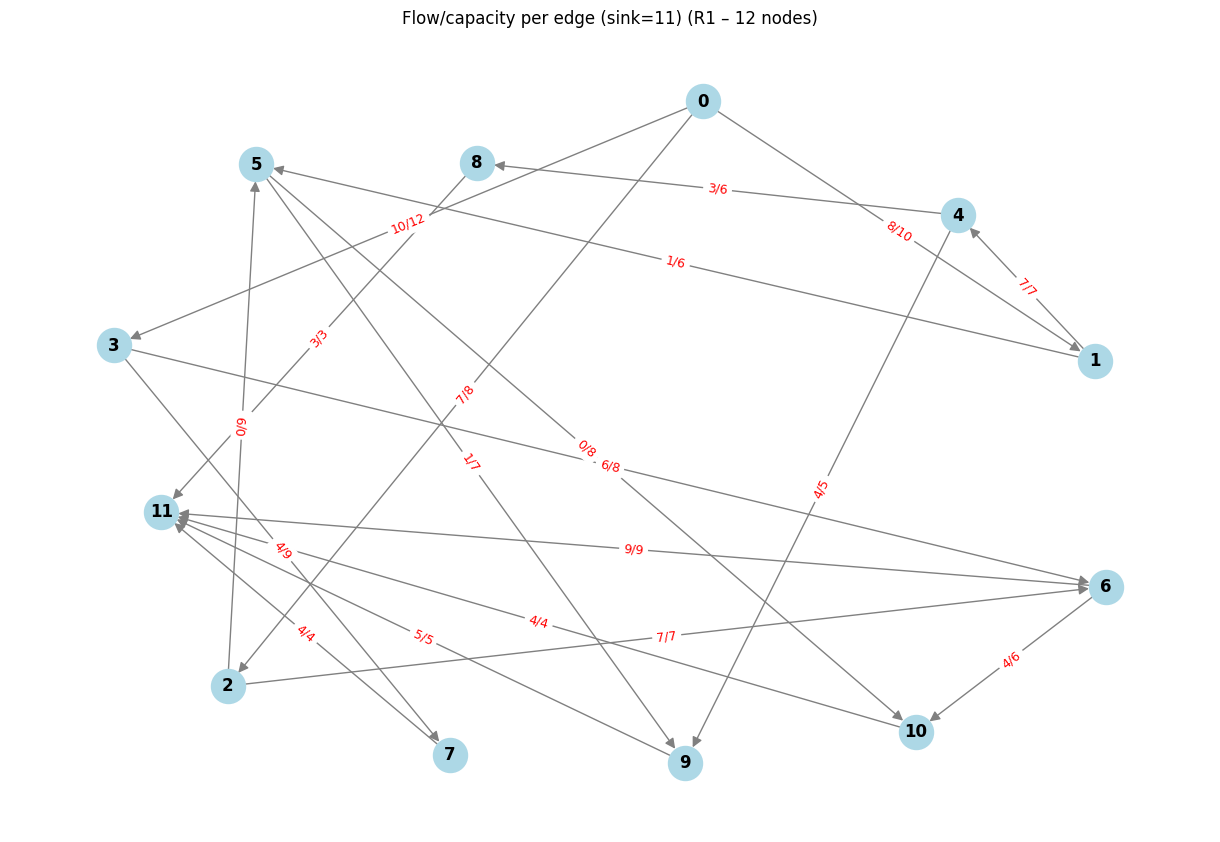

In [ ]:

graph_r1 = {
    'edges': {
        0:  [1, 2, 3],
        1:  [4, 5],
        2:  [5, 6],
        3:  [6, 7],
        4:  [8, 9],
        5:  [9, 10],
        6:  [10, 11],
        7:  [11],
        8:  [11],
        9:  [11],
        10: [11],
        11: []
    },
    'capacity': {
        (0, 1):  10, (0, 2):  8, (0, 3):  12,
        (1, 4):   7, (1, 5):  6,
        (2, 5):   9, (2, 6):  7,
        (3, 6):   8, (3, 7):  9,
        (4, 8):   6, (4, 9):  5,
        (5, 9):   7, (5, 10): 8,
        (6, 10):  6, (6, 11): 9,
        (7, 11):  4,
        (8, 11):  3,
        (9, 11):  5,
        (10, 11): 4
    }
}


source_r1, sink_r1 = 0, 11

net_r1, tf_r1 = simulated_annealing(graph_r1, source_r1, sink_r1)
print("R1 – SA total flow into sink:", tf_r1)

# ---- Edmonds-Karp ------------------------------------
G_r1 = nx.DiGraph()
for (u, v), c in graph_r1['capacity'].items():
    G_r1.add_edge(u, v, capacity=c)
tf_opt_r1 = nx.maximum_flow_value(G_r1, source_r1, sink_r1)
print("R1 – Edmonds-Karp optimum:", tf_opt_r1)


visualise_network(net_r1, graph_r1, sink_r1, " (R1 – 12 nodes)")

In [ ]:
def build_random_graph(n=30, p=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    while True:
        G = nx.gnp_random_graph(n, p, directed=True)
        if nx.is_strongly_connected(G):
            break

        G = nx.DiGraph()
        nodes = list(range(n))
        random.shuffle(nodes)
        for i in range(n):
            for j in range(i+1, n):
                G.add_edge(nodes[i], nodes[j])

        for _ in range(int(0.1*n*n)):
            u, v = random.sample(range(n), 2)
            G.add_edge(u, v)


    for u, v in G.edges():
        G[u][v]['capacity'] = random.randint(1, 10)


    graph = {'edges': {i: [] for i in range(n)}, 'capacity': {}}
    for u, v in G.edges():
        graph['edges'][u].append(v)
        graph['capacity'][(u, v)] = G[u][v]['capacity']

    return graph, G

R2 – SA flow: 5
R2 – Edmonds-Karp: 13


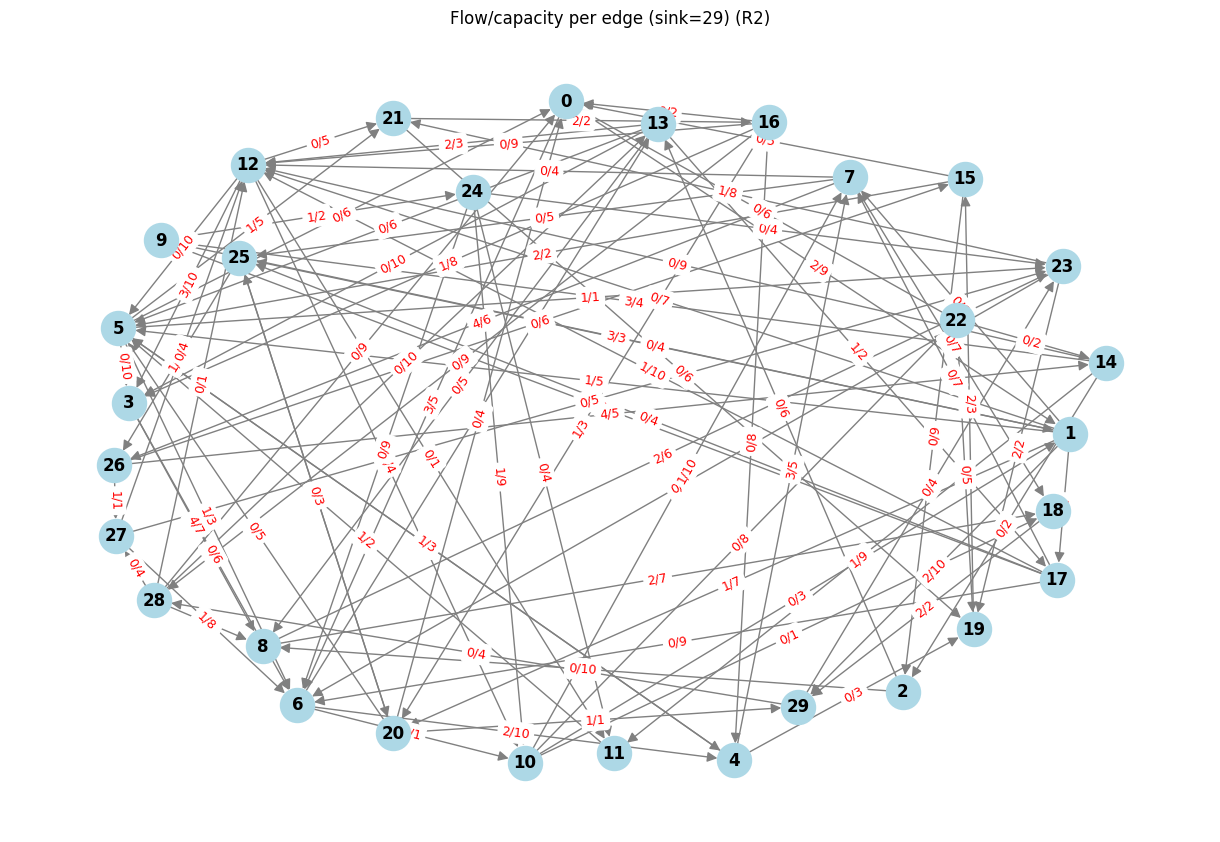

In [129]:

graph_r2, nxG_r2 = build_random_graph(30, 0.1)
source_r2, sink_r2 = 0, 29

net_r2, tf_r2 = simulated_annealing(graph_r2, source_r2, sink_r2)
tf_opt_r2 = nx.maximum_flow_value(nxG_r2, source_r2, sink_r2)
print("R2 – SA flow:", tf_r2)
print("R2 – Edmonds-Karp:", tf_opt_r2)
visualise_network(net_r2, graph_r2, sink_r2, " (R2)")

In [ ]:

def experiment(n_graphs=30, n=30, p=0.1, T_init=100):
    flows = []
    for _ in range(n_graphs):
        gr, _ = build_random_graph(n, p)
        _, tf = simulated_annealing(gr, 0, 29, T_init=T_init)
        flows.append(tf)
    return np.mean(flows), np.std(flows)



In [ ]:
avg100, std100 = experiment(T_init=100)
print("R3a – tf_net_avg(100)  = {:.2f} ± {:.2f}".format(avg100, std100))


R3a – tf_net_avg(100)  = 6.93 ± 3.05


In [124]:

avg1000, std1000 = experiment(T_init=1000)
print("R3b – tf_net_avg(1000) = {:.2f} ± {:.2f}".format(avg1000, std1000))


R3b – tf_net_avg(1000) = 6.40 ± 2.84


In [125]:
print("R3c – Difference       = {:.2f}".format(avg1000 - avg100))


R3c – Difference       = -0.53


In [126]:
if avg1000 - avg100 > 0.5:
    print(" Higher initial temperature yields noticeably higher average flow.")
else:
    print(" No significant difference – solution quality already near-optimal at T=100.")

 No significant difference – solution quality already near-optimal at T=100.


In [130]:

def r3_statistics(n_graphs=30, n=30, p=0.1):
    flows_100, flows_1000 = [], []
    for _ in range(n_graphs):
        gr, _ = build_random_graph(n, p)          # new random graph
        _, tf100   = simulated_annealing(gr, 0, 29, T_init=100)
        _, tf1000  = simulated_annealing(gr, 0, 29, T_init=1000)
        flows_100.append(tf100)
        flows_1000.append(tf1000)

    avg100  = np.mean(flows_100)
    avg1000 = np.mean(flows_1000)
    print("R3a – tf_net_avg(100)  = {:.2f}".format(avg100))
    print("R3b – tf_net_avg(1000) = {:.2f}".format(avg1000))
    print("R3c – Difference       = {:.2f}".format(avg1000 - avg100))
    if avg1000 - avg100 > 0.5:
        print(" Higher initial temperature yields noticeably higher average flow.")
    else:
        print(" No significant difference – solution quality already near-optimal at T=100.")



In [128]:
r3_statistics()

R3a – tf_net_avg(100)  = 6.93
R3b – tf_net_avg(1000) = 7.20
R3c – Difference       = 0.27
 No significant difference – solution quality already near-optimal at T=100.
